In [42]:
%matplotlib inline

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox

In [44]:
data = pd.read_csv('data/Apple Daily.csv', index_col='Date',
                   parse_dates=True)

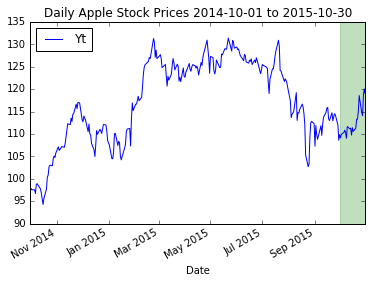

In [45]:
data.plot(y=['Yt'])
plt.title('Daily Apple Stock Prices 2014-10-01 to 2015-10-30')
plt.legend(loc='upper left')
plt.axvspan('2015-10-01', '2015-10-30', color='green', alpha=0.25)
plt.show()

In [46]:
# Delimit training and forecasting ranges
tdata = data['2014-10-01':'2015-09-30']
fdata = data['2015-10-01':'2015-10-30']

In [47]:
# Create training series and forecasting series
series = data['Yt']
tseries = tdata['Yt']
fserieslen = fdata['Yt']

In [48]:
fdata['Ytf'] = tseries[-1]
fseries = fdata['Ytf']

/home/tom/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


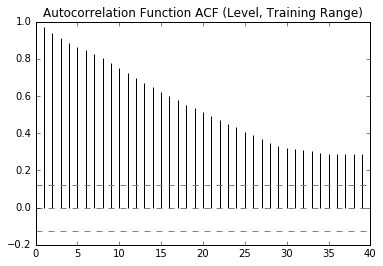

In [49]:
# Auto-correlation Function ACF calculation and chart
tseriesACF = acf(tseries)
plt.title('Autocorrelation Function ACF (Level, Training Range)')
plt.bar(range(len(tseriesACF)), tseriesACF, width=1/2)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tseries)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(tseries)), linestyle='--', color='gray')
plt.show()

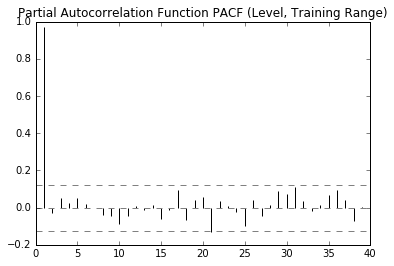

In [50]:
# Partial Auto-correlation Function PACF calculation and chart
tseriesPACF = pacf(tseries)
plt.title('Partial Autocorrelation Function PACF (Level, Training Range)')
plt.bar(range(len(tseriesPACF)), tseriesPACF, width=1/2)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tseries)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(tseries)), linestyle='--', color='gray')
plt.show()

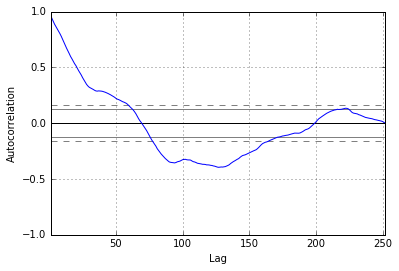

In [51]:
# using pandas autocorrelation plotting
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(tseries)

In [52]:
print("Augmented Dickey-Fuller Test ADF (Level, Training Range):")
print("")
tseriesADF = adfuller(tseries)
tseriesADFresult = pd.Series(tseriesADF[0:2], index=['Test statistic:','p-value:'])
print(tseriesADFresult)

Augmented Dickey-Fuller Test ADF (Level, Training Range):

Test statistic:   -2.225890
p-value:           0.196984
dtype: float64


p-value is greater than 0.05 and therefore TS is not stationary

/home/tom/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


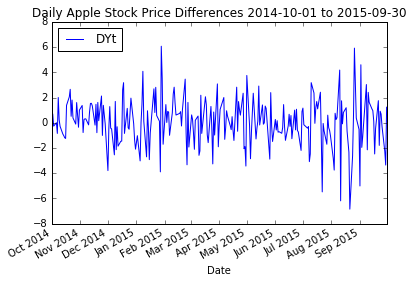

In [53]:
# differentiate TS data to see if we can make it stationary
difftseries = tseries - tseries.shift()
difftseries[0] = 0.00
tdata['DYt'] = difftseries
tdata.plot(y=['DYt'])
plt.title('Daily Apple Stock Price Differences 2014-10-01 to 2015-09-30')
plt.legend(loc='upper left')
plt.show()

In [54]:
# Run ADF again...
print("")
print("Augmented Dickey-Fuller Test ADF (First Difference, Training Range):")
print("")
difftseriesADF = adfuller(difftseries)
difftseriesADFresult = pd.Series(difftseriesADF[0:2], index=['Test statistic:','p-value:'])
print(difftseriesADFresult)


Augmented Dickey-Fuller Test ADF (First Difference, Training Range):

Test statistic:   -1.549018e+01
p-value:           2.490745e-28
dtype: float64


This time p-value is less than critical 0.05 value.  TS data is now stationary after applying first order differentiation.

In [55]:
# fit ARIMA model
# use AR of order 20 using what makes sense from ACF and PACF plots
# use first order of differntiation to make data stationary
model = ARIMA(tseries, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                   D.Yt   No. Observations:                  251
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -510.971
Method:                       css-mle   S.D. of innovations              1.853
Date:                Tue, 14 Feb 2017   AIC                           1035.943
Time:                        15:57:36   BIC                           1060.621
Sample:                    10-02-2014   HQIC                          1045.874
                         - 09-30-2015                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0537      0.098      0.550      0.583        -0.138     0.245
ar.L1.D.Yt     0.0133      0.063      0.211      0.833        -0.110     0.137
ar.L2.D.Yt    -0.0770      0.063     -1.221      0.2

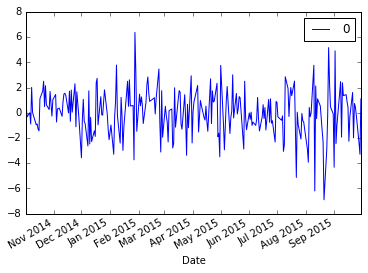

In [56]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

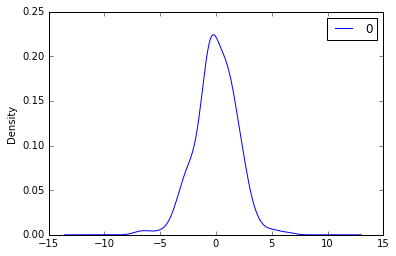

In [57]:
residuals.plot(kind='kde')

In [58]:
print(residuals.describe())

                0
count  251.000000
mean    -0.000161
std      1.856508
min     -6.906719
25%     -0.990241
50%     -0.059189
75%      1.197781
max      6.375727


In [59]:
# Ljung-Box Auto-correlation Test

print("")
print("Ljung-Box Autocorrelation Test:")
print("")
RWDresLB = acorr_ljungbox(residuals, lags= 10)
RWDresLBseries = pd.Series(RWDresLB, index=['Q-statistic:','p-value:'])
RWDresLBqstat = (RWDresLBseries['Q-statistic:'])
RWDresLBpval = (RWDresLBseries['p-value:'])
RWDresLBdata = [{'Q-statistic:': RWDresLBqstat[0], 'p-value:': RWDresLBpval[0]},
                {'Q-statistic:': RWDresLBqstat[1], 'p-value:': RWDresLBpval[1]},
                {'Q-statistic:': RWDresLBqstat[2], 'p-value:': RWDresLBpval[2]},
                {'Q-statistic:': RWDresLBqstat[3], 'p-value:': RWDresLBpval[3]},
                {'Q-statistic:': RWDresLBqstat[4], 'p-value:': RWDresLBpval[4]},
                {'Q-statistic:': RWDresLBqstat[5], 'p-value:': RWDresLBpval[5]},
                {'Q-statistic:': RWDresLBqstat[6], 'p-value:': RWDresLBpval[6]},
                {'Q-statistic:': RWDresLBqstat[7], 'p-value:': RWDresLBpval[7]},
                {'Q-statistic:': RWDresLBqstat[8], 'p-value:': RWDresLBpval[8]},
                {'Q-statistic:': RWDresLBqstat[9], 'p-value:': RWDresLBpval[9]}]
RWDresLBtable = pd.DataFrame(RWDresLBdata)
print(RWDresLBtable)
print("")



Ljung-Box Autocorrelation Test:

   Q-statistic:  p-value:
0      0.000002  0.998985
1      0.001540  0.999230
2      0.004368  0.999923
3      0.004904  0.999997
4      0.034805  0.999988
5      0.091179  0.999985
6      0.537401  0.999298
7      0.539649  0.999822
8      1.679485  0.995583
9      1.966034  0.996594



Ljung-Box test p-values are all above 0.05.  With 95% confidence we can say that residuals represent white noise and no trend information can be found in the residuals.

In [60]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=126.981314, expected=125.490000
predicted=125.674836, expected=126.490000
predicted=126.733689, expected=125.920000
predicted=126.054330, expected=126.990000
predicted=127.080033, expected=126.380000
predicted=126.577884, expected=125.640000
predicted=125.806471, expected=123.440000
predicted=123.802941, expected=124.330000
predicted=124.599628, expected=125.490000
predicted=125.526276, expected=125.330000
predicted=125.214411, expected=124.900000
predicted=125.199770, expected=124.590000
predicted=124.865091, expected=121.500000
predicted=121.667542, expected=119.020000
predicted=119.389320, expected=122.200000
predicted=122.605042, expected=124.560000
predicted=124.188079, expected=124.510000
predicted=124.277422, expected=125.710000
predicted=126.155324, expected=127.390000
predicted=127.411267, expected=128.490000
predicted=128.351056, expected=130.910000
predicted=131.087378, expected=129.610000
predicted=129.580213, expected=124.120000
predicted=124.259290, expected=124

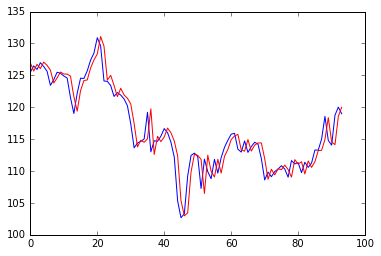

In [61]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()